<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Enhancing Data Science Outcomes With Efficient Workflow #

## 03 - Model Deployment for Inference ##
In this lab, you will learn how to deploy a model on Triton Inference Server. We'll learn how to create the model directory structures and configuration files within Triton Inference Server and how to send inference requests to the models deployed within it.

**Table of Contents**
<br>
In this notebook, we will deploy models using Triton Inference Server with the Forest Inference Library backend. This notebook covers the below sections: 
1. [Deploying Models in Triton](#s1-1)
    * [Introduction to Triton Inference Server](#s1-1.1)
    * [Server](#s1-1.2)
    * [Client](#s1-1.3)
    * [Model Repository](#s1-1.4)
2. [Load Existing XGBoost Model](#s1-2)
3. [Configure Triton Inference Server](#s1-3)
    * [Exercise #1 - Model Configuration](#s1-e1)
4. [Run Inference on Triton Inference Server](#s1-4)
    * [Server Health Status](#s1-4.1)
    * [Send Inference Request to Server](#s1-4.2)
    * [Run Batch Inference](#s1-4.3)
5. [Conclusion](#s1-5)

<a name='s1-1'></a>
## Deploying Models in Triton ##
Organizations tree-based models for a significant amount of mission-critical data, therefore it has become increasingly important to make deploying such models easy, efficient, and performant. NVIDIA [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server) offers a complete solution for deploying tree models through the [Forest Inference Library backend](https://github.com/triton-inference-server/fil_backend). Based on the RAPIDS [Forest Inference Library (FIL)](https://docs.rapids.ai/api/cuml/stable/api/#forest-inferencing), the Triton Inference Server FIL backend allows us to achieve optimal throughput/latency. 

<a name='s1-1.1'></a>
### Introduction to Triton Inference Server ###
NVIDIA [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server) simplifies the deployment of AI models at scale in production. Triton is an open-source, inference-serving software that lets teams deploy trained AI models on any GPU or CPU-based infrastructure, cloud, data center, or edge. 

The below figure shows the Triton Inference Server high-level architecture. The model repository is a _file-system based repository_ of the models that Triton will make available for inferencing. Inference requests arrive at the server via either [HTTP/REST](https://en.wikipedia.org/wiki/Representational_state_transfer), [gRPC](https://en.wikipedia.org/wiki/GRPC), or by the C API and are then routed to the appropriate per-model scheduler. Triton implements multiple scheduling and batching algorithms that can be configured on a model-by-model basis. Each model's scheduler optionally performs batching of inference requests and then passes the requests to the backend corresponding to the model type. The backend performs inferencing using the inputs provided in the batched requests to produce the requested outputs. The outputs are then returned.

<p><img src='images/triton_server_architecture.png' width='720'/></p>

<a name='s1-1.2'></a>
### Server ###
Setting up the Triton Inference Server requires software for the server and the client. We can get started with Triton Inference Server by pulling the [container](https://ngc.nvidia.com/catalog/containers/nvidia:tritonserver) from the NVIDIA NGC catalog. In this lab, we already have Triton Inference Server instance running. The code to run a Triton Server Instance is shown below. More details can be found in the [QuickStart Documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/quickstart.md) and [Build Documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/build.md). 

```
docker run \
  --gpus=1 \
  --ipc=host --rm \
  --shm-size=1g \
  --ulimit memlock=-1 \
  --ulimit stack=67108864 \
  -p 8000:8000 -p 8001:8001 -p 8002:8002 \
  -v /models:/models \
  nvcr.io/nvidia/tritonserver:20.12-py3 \
  tritonserver \
  --model-repository=/models \
  --exit-on-error=false \
  --model-control-mode=poll \
  --repository-poll-secs 30
```

<a name='s1-1.3'></a>
### Client ###
We've also installed the Triton Inference Server Client libraries to provide APIs that make it easy to communicate with Triton from any C++ or Python application. Using these libraries, we can send either HTTP/REST or gRPC requests to Triton to access all its capabilities: inferencing, status and health, statistics and metrics, model repository management, etc. These libraries also support using system and CUDA shared memory for passing inputs to and receiving outputs from Triton. 

The easiest way to get the Python client library is to use `pip` to install the `tritonclient` module, as detailed below. For more details on how to download or build the Triton Inference Server Client libraries, please see the documentation [here](https://github.com/triton-inference-server/server/blob/r20.12/docs/client_libraries.md), as well as examples that show the use of both the C++ and Python libraries.

```
pip install nvidia-pyindex
pip install tritonclient[all]
```

<a name='s1-1.4'></a>
### Model Repository ###
Triton Inference Server serves models within a model repository. When we started Triton Inference Server, we needed to specify the model repository where the models reside:

```
tritonserver --model-repository=/models
```

Each model resides in its own model subdirectory within the model repository - i.e., each directory within `/models` represents a unique model. For example, in this notebook we'll be deploying our `classification_model`. All models typically follow a similar directory structure. Within each of these directories, we'll create a configuration file `config.pbtxt` that details information about the model - e.g., _batch size_, _input shapes_, _deployment backend_ (FIL, PyTorch, ONNX, TensorFlow, TensorRT, etc.) and more. Additionally, we can create one or more versions of our model. Each version lives under a subdirectory name with the respective version number, starting with `1`. It's within this subdirectory where our model files reside. 

```
root@server:/models$ tree
.
├── classification_model
│   ├── 1
│   │   └── xgboost.json
│   └── config.pbtxt
│

```

For more details on how to work with model repositories and model directory structures in Triton Inference Server, please see the [documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/model_repository.md). Below, we'll create the model directory structure for our classification model.

In [1]:
!mkdir -p models/classification_model/1

!cp sample_xgboost.json models/classification_model/1/xgboost.json

<a name='s1-2'></a>
## Load Existing XGBoost Model ##
We will compare model inference performance between XGBoost and Triton Inference Server. We start by loading an existing XGBoost model that is similar to the ones we created from the previous exercises. 

In [2]:
# import dependencies
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
from cuml.metrics import accuracy_score

import dask_cudf
import xgboost
import time

import numpy as np
import matplotlib.pyplot as plt

# instantiate a Client
cluster=LocalCUDACluster()
client=Client(cluster)

2023-12-24 21:22:27,709 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 21:22:27,709 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-24 21:22:27,709 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 21:22:27,709 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-24 21:22:27,723 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 21:22:27,723 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-24 21:22:27,728 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 21:22:27,728 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [3]:
# initializing list
features_list=['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 
               'price', 'ts_hour', 'ts_minute', 'ts_weekday', 
               'brand_target_sum', 'brand_count', 'cat_0_target_sum', 
               'cat_0_count', 'cat_1_target_sum', 'cat_1_count', 
               'cat_2_target_sum', 'cat_2_count', 'cat_3_target_sum', 
               'cat_3_count', 'TE_brand_target', 'TE_cat_0_target', 
               'TE_cat_1_target', 'TE_cat_2_target', 'TE_cat_3_target', 
               'relative_price_product', 'relative_price_category']
         
include=features_list+['target']

In [4]:
# load data with dask_cudf
parquet_dir='processed_parquet'
ddf=dask_cudf.read_parquet(parquet_dir, columns=include)

# load data into single GPU memory
gdf=ddf.compute()

print(f'Total of {len(gdf)} records. ')

Total of 2461697 records. 


In [5]:
# load model
xgb_clf=xgboost.Booster()
xgb_clf.load_model('sample_xgboost.json')

In [6]:
# XGBoost treats all data as 32-bit float internally
y=gdf['target'].astype('float32')
X=gdf[features_list].astype('float32')

# create DMatrix
dmatrix=xgboost.DMatrix(X, y) 

# predict
start=time.time()
prediction_test=xgb_clf.predict(dmatrix)
elapsed_time=time.time()-start

print(f'Accuracy score: {round(float(accuracy_score(y, prediction_test>0.5))*100, 2)}%')

xgboost_throughput=round(len(X)/elapsed_time, 2)
print(f'Throughput is: {xgboost_throughput} per seconds. ')

Accuracy score: 62.37%
Throughput is: 2506723.92 per seconds. 


<a name='s1-3'></a>
## Configure Triton Inference Server ##

<a name='s1-e1'></a>
### Exercise #1 - Model Configuration ###
With our model directory set up, we now turn our attention to creating the configuration file for our model. A minimal model configuration must specify the name of the model, the `platform` and/or backend properties, the `max_batch_size` property, and the `input` and `output` tensors of the model (name, data type, and shape). For more details on how to create model configuration files within Triton Inference Server, please see the [documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/model_configuration.md). 
* `max_batch_size`: the maximum batch size that can be passed to this model. In general, the only limit on the size of batches passed to a FIL backend is the memory available with which to process them. For GPU execution, the available memory is determined by the size of Triton's CUDA memory pool, which can be set via a command line argument when starting the server
* `input`: options in this section tell Triton the number of features to expect for each input sample
* `output`: options in this section tell Triton how many output values there will be for each sample. If the "predict_proba" option (described further on) is set to true, then a probability value will be returned for each class. Otherwise, a single value will be returned indicating the class predicted for the given sample
* `instance_group`: this determines how many instances of this model will be created and whether they will use the GPU or CPU.
* `model_type`: a string indicating what format the model is in ("xgboost_json" in this example, but "xgboost", "lightgbm", and "tl_checkpoint" are valid formats as well)
* `predict_proba`: if set to `True`, probability values will be returned for each class rather than just a class prediction
* `output_class`: `True` for classification models, `False` for regression models
* `threshold`: a score threshold for determining classification. When `output_class` is set to `True`, this must be provided, although it will not be used if predict_proba is also set to `True`
* `storage_type`: in general, using "AUTO" for this setting should meet most usecases. If "AUTO" storage is selected, FIL will load the model using either a sparse or dense representation based on the approximate size of the model. In some cases, you may want to explicitly set this to "SPARSE" in order to reduce the memory footprint of large models.

**Instructions**:<br>
* Modify the `<FIXME>`s only and execute the cell to create the `config.pbtxt` file for the defect classification model. 

In [7]:
features=len(features_list)
num_classes=2

bytes_per_sample = (features + num_classes) * 4
max_batch_size = 50000 # or MAX_MEMORY_BYTES // bytes_per_sample

configuration = f"""
backend: "fil"
max_batch_size: {max_batch_size}
input: [
  {{
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ {features} ]
  }}
]
output: [
  {{
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ {num_classes} ]
  }}
]
instance_group [{{ kind: KIND_GPU }}]
parameters [
  {{
    key: "model_type"
    value: {{ string_value: "xgboost_json" }}
  }},
  {{
    key: "predict_proba"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "output_class"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "threshold"
    value: {{ string_value: "0.5" }}
  }}
]
dynamic_batching {{
  max_queue_delay_microseconds: 100
}}
"""

with open('models/classification_model/config.pbtxt', 'w') as file:
    file.write(configuration)

Click ... to show **solution**. 

<a name='s1-4'></a>
## Run Inference on Triton Inference Server ##
With our model directory structures created, models defined and exported, and configuration files created, we will now wait for Triton Inference Server to load our models. We have set up this lab to use Triton Inference Server in **polling** mode. This means that Triton Inference Server will continuously poll for modifications to our models or for newly created models - once every 30 seconds. Please run the cell below to allow time for Triton Inference Server to poll for new models/modifications before proceeding. Due to the asynchronous nature of this step, we have added 15 seconds to be safe.

<a name='s1-4.1'></a>
### Server Health Status ###

In [8]:
# DO NOT CHANGE THIS CELL
!sleep 45

At this point, our models should be deployed and ready to use! To confirm Triton Inference Server is up and running, we can send a `curl` request to the below URL. The HTTP request returns status _200_ if Triton is ready and _non-200_ if it is not ready. We can also send a `curl` request to our model endpoints to confirm our models are deployed and ready to use. Additionally, we will also see information about our models such:
* The name of our model
* The versions available for our model
* The backend platform (e.g., tensort_rt, pytorch_libtorch, onnxruntime_onnx)
* The inputs and outputs, with their respective names, data types, and shapes

In [9]:
# DO NOT CHANGE THIS CELL
!curl -v triton:8000/v2/health/ready

*   Trying 172.18.0.2:8000...
* Connected to triton (172.18.0.2) port 8000 (#0)
> GET /v2/health/ready HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.86.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Length: 0
< Content-Type: text/plain
< 
* Connection #0 to host triton left intact


In [10]:
# DO NOT CHANGE THIS CELL
!curl -v triton:8000/v2/models/classification_model

*   Trying 172.18.0.2:8000...
* Connected to triton (172.18.0.2) port 8000 (#0)
> GET /v2/models/classification_model HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.86.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Type: application/json
< Content-Length: 196
< 
* Connection #0 to host triton left intact
{"name":"classification_model","versions":["1"],"platform":"fil","inputs":[{"name":"input__0","datatype":"FP32","shape":[-1,26]}],"outputs":[{"name":"output__0","datatype":"FP32","shape":[-1,2]}]}

<a name='s1-4.2'></a>
### Send Inference Request to Server ###
With our models deployed, it is now time to send inference requests to our models. First, we'll load the `tritonclient.http` module. We will also define the input and output names of our model, the name of our model, the URL where our models are deployed with Triton Inference Server (in this case the host `triton:8000`), and our model version.

In [11]:
# import dependencies
import tritonclient.http as tritonhttpclient
from tritonclient import utils as triton_utils
HOST='triton'
PORT=8000
TIMEOUT=60
VERBOSE=False
model_name='classification_model'
model_version='1'

We'll instantiate our client `triton_client` using the `tritonhttpclient.InferenceServerClient` class access the model metadata with the `get_model_metadata()` method as well as get our model configuration with the `get_model_config()` method.

In [12]:
# instantiate client
triton_client=tritonhttpclient.InferenceServerClient(url=f'{HOST}:{PORT}', verbose=VERBOSE)

We'll instantiate a placeholder for our input data using the input name, shape, and data type expected. We'll set the data of the input to be the NumPy array representation of our image. We'll also instantiate a placeholder for our output data using just the output name. Lastly, we'll submit our input to the Triton Inference Server using the `triton_client.infer()` method, specifying our model name, model version, inputs, and outputs and convert our result to a NumPy array.

In [13]:
# define function to make inference request
def triton_predict(model_name, arr):
    triton_input = tritonhttpclient.InferInput('input__0', arr.shape, 'FP32')
    triton_input.set_data_from_numpy(arr)
    triton_output = tritonhttpclient.InferRequestedOutput('output__0')
    response = triton_client.infer(model_name, model_version='1', inputs=[triton_input], outputs=[triton_output])
    return response.as_numpy('output__0')

In [14]:
# conver to NumPy array
np_data=X.to_numpy()

triton_result=triton_predict('classification_model', np_data[0:5])

print("Result computed on Triton: ")
print(triton_result)

Result computed on Triton: 
[[0.49424398 0.505756  ]
 [0.4811334  0.5188666 ]
 [0.53086543 0.4691346 ]
 [0.58638287 0.41361716]
 [0.54397285 0.45602712]]


<a name='s1-4.3'></a>
### Run Batch Inference ###

In [15]:
# run batch inference
time_list=[]
batch_size=10000
iterations=len(np_data)//batch_size
count=0

# iterate until no last batch
for i in range(iterations): 
    start=time.time()
    response=triton_predict('classification_model', np_data[count:count+batch_size])
    time_list.append(time.time()-start)
    count+=batch_size

triton_throughput=round(count/sum(time_list), 2)
print(f'Throughput is: {triton_throughput} per seconds. ')

Throughput is: 1977689.88 per seconds. 


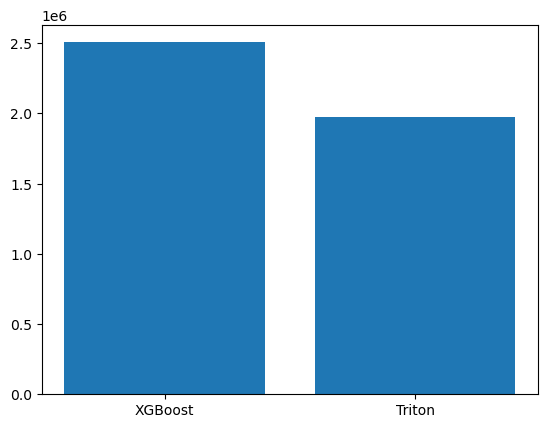

In [16]:
# plot comparison
plt.bar(x=['XGBoost', 'Triton'], height=[xgboost_throughput, triton_throughput])
plt.show()

<a name='s1-5'></a>
## Conclusion ##
In this notebook, we showed how to deploy an XGBoost model in Triton using the FIL backend. While it is possible to deploy these models on both CPU and GPU in Triton, GPU-deployed models offer far higher throughput at lower latency. As a result, we can deploy more sophisticated models on the GPU for any given latency budget and thereby obtain far more accurate results. While we have focused on XGBoost in this example, FIL also natively supports LightGBM's text serialization format as well as Treelite's checkpoint format. Thus, the same general steps can be used to serve LightGBM models and any Treelite-convertible model (including scikit-learn and cuML forest models). With the new FIL backend, Triton is now ready to serve forest models of all kinds in production, whether on their own or in concert with any of the deep-learning models supported by Triton.

**Well Done!** When you're finished, please complete the assessment before moving onto the survey. 

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>